本节以上一节介绍的目标检测算法YOLOv3来完成病虫害检测任务为例，介绍一个更加通用的进行计算机视觉任务研发的全流程，主要涵盖如下内容：

* 通用的计算机视觉任务研发全流程：介绍通用的计算机视觉任务研发全流程。
* 林业病虫害数据集：介绍数据集结构及数据预处理方法。
* YOLOv3目标检测模型：介绍算法原理，及如何应用林业病虫害数据集进行模型训练和测试。

# 5.3 目标检测YOLOv3实战：叶病虫害检测

**基本的计算机视觉任务研发全流程** 

首先简单回顾下第四章介绍的基本的计算机视觉任务研发全流程：

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/6a03b4c34aab474ea3d3f11a811c28f7f0927553d2b74003b5ebb9a20c297416" width = "700"></center>
<center><br>图1：基本的视觉任务研发全流程</br></center>
<br></br>

**通用的视觉任务研发全流程**

目标检测模型构建流程如 **图2** 所示，和基本的计算机视觉任务研发全流程(**图1**)相比增加了**检测头结构**和**多尺度检测结构**2部分。目标检测既需要识别出物体的类别，还需要标示出每个目标的位置，因此我们增加检测头结构，用于计算预测框是否包含物体的概率、预测框位置坐标以及物体属于每个类别的概率。同时在目标检测中，检测的物体形状尺寸可能变化比较大，使用单一尺寸的特征图做预测容易造成漏检，而且像素点包含的语义信息可能不够丰富，难以提取到有效的特征模式，因此在目标检测中将高级层的特征图尺寸放大之后跟低层级的特征图进行融合，从而检测多尺度目标。


<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/d26c234a73b249e59cabc0d4b7ff9b03491b7b4fc7fc49eeb2dcaaef70f5c79b" width = "700"></center>
<center><br>图2：通用的视觉任务研发全流程</br></center>
<br></br>

* 数据处理：根据网络接收的数据格式，完成相应的预处理操作，保证模型正常读取，同时产生候选区域；
* 模型构建：设计目标检测网络结构；
* 特征提取：使用卷积神经网络提取特征；
* 检测头设计：计算预测框是否包含物体的概率、预测框位置坐标、物体属于每个类别概率；
* 多尺度检测：将高级层的特征图尺寸放大之后跟低层级的特征图进行融合；
* 损失函数：模型优化的目标；
* 模型评估：在模型训练中或训练结束后岁模型进行评估测试，观察准确率；
* 模型预测：使用训练好的模型进行测试，也需要准备数据和模型特征提取，最后对结果进行解析；
* 模型部署：通常需要将训练好的模型在特定环境(服务器、手机等)中运行，即在设备端运行推理任务。

接下来具体介绍流程中各节点的原理和代码实现。

## 5.3.1 数据处理

### 5.3.1.1 数据集介绍

在本课程中，将使用百度与林业大学合作开发的林业病虫害防治项目中用到昆虫数据集。AI识虫数据集结构如下：

* 提供了2183张图片，其中训练集1693张，验证集245，测试集245张。
* 包含7种昆虫，分别是Boerner、Leconte、Linnaeus、acuminatus、armandi、coleoptera和linnaeus。
* 包含了图片和标注

### 5.3.1.2 数据集下载和标签格式

请读者先将数据解压，并存放在insects目录下。

In [ ]:
# 解压数据脚本，第一次运行时打开注释，将文件解压到work目录下
!unzip -q -d  /home/aistudio/work /home/aistudio/data/data19638/insects.zip

将数据解压之后，可以看到insects目录下的结构如下所示。

        insects
            |---train
            |         |---annotations
            |         |         |---xmls
            |         |                  |---100.xml
            |         |                  |---101.xml
            |         |                  |---...
            |         |---images
            |                   |---100.jpeg
            |                   |---101.jpeg
            |                   |---...
            |---val
            |        |---annotations
            |        |         |---xmls
            |        |                  |---1221.xml
            |        |                  |---1277.xml
            |        |                  |---...
            |        |---images
            |                  |---1221.jpeg
            |                  |---1277.jpeg
            |                  |---...
            |---test
                     |---images
                               |---1833.jpeg
                               |---1838.jpeg
                               |---...

insects包含train、val和test三个文件夹。`train/annotations/xmls`目录下存放着图片的标注。每个xml文件是对一张图片的说明，包括图片尺寸、包含的昆虫名称、在图片上出现的位置等信息。

第四章介绍的分类数据集包含图片和标注信息(物体类别)，目标检测的数据比分类复杂，一张图像中，需要标记出各个目标区域的位置和类别。

一般的目标区域位置用一个矩形框来表示，一般用以下3种方式表达：

|         表达方式    |                 说明               |
| :----------------: | :--------------------------------: |
|     x1,y1,x2,y2    | (x1,y1)为左上角坐标，(x2,y2)为右下角坐标  |  
|     x1,y1,w,h      | (x1,y1)为左上角坐标，w为目标区域宽度，h为目标区域高度  |
|     xc,yc,w,h    | (xc,yc)为目标区域中心坐标，w为目标区域宽度，h为目标区域高度  |  

常见的目标检测数据集如Pascal VOC采用的`[x1,y1,x2,y2]` 表示物体的bounding box, COCO采用的`[x1,y1,w,h]` 表示物体的bounding box, [Cformat](https://cocodataset.org/#format-data).

```
<annotation>
        <folder>刘霏霏</folder>
        <filename>100.jpeg</filename>
        <path>/home/fion/桌面/刘霏霏/100.jpeg</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>1336</width>
                <height>1336</height>
                <depth>3</depth>
        </size>
        <segmented>0</segmented>
        <object>
                <name>Boerner</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>500</xmin>
                        <ymin>893</ymin>
                        <xmax>656</xmax>
                        <ymax>966</ymax>
                </bndbox>
        </object>
        <object>
			...
        </object>
        ...

</annotation>
```

上面列出的xml文件中的主要参数说明如下：

* size：图片尺寸。

* object：图片中包含的物体，一张图片可能中包含多个物体。

 -- name：昆虫名称；
 
 -- bndbox：物体真实框；
 
 -- difficult：识别是否困难。


下面我们将从数据集中读取xml文件，将每张图片的标注信息读取出来。在读取具体的标注文件之前，我们先完成一件事情，就是将昆虫的类别名字（字符串）转化成数字表示的类别。因为神经网络里面计算时需要的输入类型是数值型的，所以需要将字符串表示的类别转化成具体的数字。昆虫类别名称的列表是：['Boerner', 'Leconte', 'Linnaeus', 'acuminatus', 'armandi', 'coleoptera', 'linnaeus']，这里我们约定此列表中：'Boerner'对应类别0，'Leconte'对应类别1，...，'linnaeus'对应类别6。使用下面的程序可以得到表示名称字符串和数字类别之间映射关系的字典。

In [ ]:
INSECT_NAMES = ['Boerner', 'Leconte', 'Linnaeus', 
                'acuminatus', 'armandi', 'coleoptera', 'linnaeus']

def get_insect_names():
    """
    return a dict, as following,
        {'Boerner': 0,
         'Leconte': 1,
         'Linnaeus': 2, 
         'acuminatus': 3,
         'armandi': 4,
         'coleoptera': 5,
         'linnaeus': 6
        }
    It can map the insect name into an integer label.
    """
    insect_category2id = {}
    for i, item in enumerate(INSECT_NAMES):
        insect_category2id[item] = i

    return insect_category2id

In [ ]:
cname2cid = get_insect_names()
cname2cid

{'Boerner': 0,
 'Leconte': 1,
 'Linnaeus': 2,
 'acuminatus': 3,
 'armandi': 4,
 'coleoptera': 5,
 'linnaeus': 6}

调用get_insect_names函数返回一个dict，描述了昆虫名称和数字类别之间的映射关系。下面的程序从annotations/xml目录下面读取所有文件标注信息。

In [ ]:
import os
import numpy as np
import xml.etree.ElementTree as ET

def get_annotations(cname2cid, datadir):
    filenames = os.listdir(os.path.join(datadir, 'annotations', 'xmls'))
    records = []
    ct = 0
    for fname in filenames:
        fid = fname.split('.')[0]
        fpath = os.path.join(datadir, 'annotations', 'xmls', fname)
        img_file = os.path.join(datadir, 'images', fid + '.jpeg')
        tree = ET.parse(fpath)

        if tree.find('id') is None:
            im_id = np.array([ct])
        else:
            im_id = np.array([int(tree.find('id').text)])

        objs = tree.findall('object')
        im_w = float(tree.find('size').find('width').text)
        im_h = float(tree.find('size').find('height').text)
        gt_bbox = np.zeros((len(objs), 4), dtype=np.float32)
        gt_class = np.zeros((len(objs), ), dtype=np.int32)
        is_crowd = np.zeros((len(objs), ), dtype=np.int32)
        difficult = np.zeros((len(objs), ), dtype=np.int32)
        for i, obj in enumerate(objs):
            cname = obj.find('name').text
            gt_class[i] = cname2cid[cname]
            _difficult = int(obj.find('difficult').text)
            x1 = float(obj.find('bndbox').find('xmin').text)
            y1 = float(obj.find('bndbox').find('ymin').text)
            x2 = float(obj.find('bndbox').find('xmax').text)
            y2 = float(obj.find('bndbox').find('ymax').text)
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(im_w - 1, x2)
            y2 = min(im_h - 1, y2)
            # 这里使用xywh格式来表示目标物体真实框
            gt_bbox[i] = [(x1+x2)/2.0 , (y1+y2)/2.0, x2-x1+1., y2-y1+1.]
            is_crowd[i] = 0
            difficult[i] = _difficult

        voc_rec = {
            'im_file': img_file,
            'im_id': im_id,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
            }
        if len(objs) != 0:
            records.append(voc_rec)
        ct += 1
    return records

In [ ]:
TRAINDIR = '/home/aistudio/work/insects/train'
TESTDIR = '/home/aistudio/work/insects/test'
VALIDDIR = '/home/aistudio/work/insects/val'
cname2cid = get_insect_names()
records = get_annotations(cname2cid, TRAINDIR)

print('records num:{}\n recored[0]:{}'.format(len(records), records[0]))

records num:1693
 recored[0]:{'im_file': '/home/aistudio/work/insects/train/images/493.jpeg', 'im_id': array([0]), 'h': 1258.0, 'w': 1258.0, 'is_crowd': array([0, 0, 0, 0, 0], dtype=int32), 'gt_class': array([0, 1, 5, 2, 4], dtype=int32), 'gt_bbox': array([[503. , 701.5,  71. , 152. ],
       [820.5, 603. , 116. , 119. ],
       [644. , 447. ,  75. ,  43. ],
       [695.5, 749. ,  50. ,  99. ],
       [532. , 524.5,  63. ,  98. ]], dtype=float32), 'gt_poly': [], 'difficult': array([0, 0, 0, 0, 0], dtype=int32)}


通过上面的程序，将所有训练数据集的标注数据全部读取出来了，存放在records列表下面，其中每一个元素是一张图片的标注数据，包含了图片存放地址，图片id，图片高度和宽度，图片中所包含的目标物体的种类和位置。

### 5.3.1.3 数据预处理

数据预处理是训练神经网络时非常重要的步骤。合适的预处理方法，可以帮助模型更好的收敛并防止过拟合。然后需要对这些数据进行预处理，为了保证网络运行的速度，通常还要对数据预处理进行加速。

首先我们需要从磁盘读入数据，前面已经将图片的所有描述信息保存在records中了，其中每一个元素都包含了一张图片的描述，下面的程序展示了如何根据records里面的描述读取图片及标注。

In [ ]:
# 数据读取
import cv2

def get_bbox(gt_bbox, gt_class):
    # 对于一般的检测任务来说，一张图片上往往会有多个目标物体
    # 设置参数MAX_NUM = 50， 即一张图片最多取50个真实框；如果真实
    # 框的数目少于50个，则将不足部分的gt_bbox, gt_class和gt_score的各项数值全设置为0
    MAX_NUM = 50
    gt_bbox2 = np.zeros((MAX_NUM, 4))
    gt_class2 = np.zeros((MAX_NUM,))
    for i in range(len(gt_bbox)):
        gt_bbox2[i, :] = gt_bbox[i, :]
        gt_class2[i] = gt_class[i]
        if i >= MAX_NUM:
            break
    return gt_bbox2, gt_class2

def get_img_data_from_file(record):
    """
    record is a dict as following,
      record = {
            'im_file': img_file,
            'im_id': im_id,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
            }
    """
    im_file = record['im_file']
    h = record['h']
    w = record['w']
    is_crowd = record['is_crowd']
    gt_class = record['gt_class']
    gt_bbox = record['gt_bbox']
    difficult = record['difficult']

    img = cv2.imread(im_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # check if h and w in record equals that read from img
    assert img.shape[0] == int(h), \
             "image height of {} inconsistent in record({}) and img file({})".format(
               im_file, h, img.shape[0])

    assert img.shape[1] == int(w), \
             "image width of {} inconsistent in record({}) and img file({})".format(
               im_file, w, img.shape[1])

    gt_boxes, gt_labels = get_bbox(gt_bbox, gt_class)

    # gt_bbox 用相对值
    gt_boxes[:, 0] = gt_boxes[:, 0] / float(w)
    gt_boxes[:, 1] = gt_boxes[:, 1] / float(h)
    gt_boxes[:, 2] = gt_boxes[:, 2] / float(w)
    gt_boxes[:, 3] = gt_boxes[:, 3] / float(h)
  
    return img, gt_boxes, gt_labels, (h, w)

In [ ]:
record = records[0]
img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
print('img shape:{}, \n gt_labels:{}, \n scales:{}\n'.format(img.shape, gt_labels, scales))

img shape:(1258, 1258, 3), 
 gt_labels:[0. 1. 5. 2. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], 
 scales:(1258.0, 1258.0)



`get_img_data_from_file()`函数可以返回图片数据的数据，它们是图像数据img，真实框坐标gt_boxes，真实框包含的物体类别gt_labels，图像尺寸scales。

在计算机视觉中，通常会对图像做一些随机的变化，产生相似但又不完全相同的样本。主要作用是扩大训练数据集，抑制过拟合，提升模型的泛化能力，常用的方法主要有以下几种：
- 随机改变亮暗、对比度和颜色
- 随机填充
- 随机缩放
- 随机翻转
- 随机打乱真实框排列顺序

下面我们分别使用numpy 实现这些数据增强方法。

#### **随机改变亮暗、对比度和颜色等**

read image from file /home/aistudio/work/insects/train/images/493.jpeg


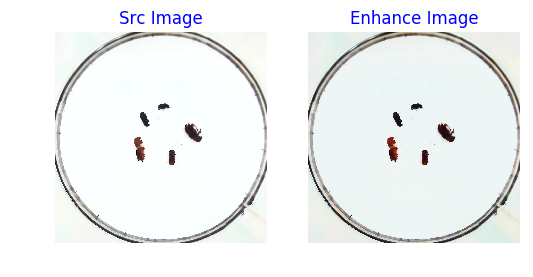

In [ ]:
import numpy as np
import cv2
from PIL import Image, ImageEnhance
import random

# 随机改变亮暗、对比度和颜色等
def random_distort(img):
    # 随机改变亮度
    def random_brightness(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Brightness(img).enhance(e)
    # 随机改变对比度
    def random_contrast(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Contrast(img).enhance(e)
    # 随机改变颜色
    def random_color(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Color(img).enhance(e)

    ops = [random_brightness, random_contrast, random_color]
    np.random.shuffle(ops)

    img = Image.fromarray(img)
    img = ops[0](img)
    img = ops[1](img)
    img = ops[2](img)
    img = np.asarray(img)

    return img

# 定义可视化函数，用于对比原图和图像增强的效果
import matplotlib.pyplot as plt
%matplotlib inline
def visualize(srcimg, img_enhance):
    # 图像可视化
    plt.figure(num=2, figsize=(6,12))
    plt.subplot(1,2,1)
    plt.title('Src Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(srcimg) # 显示原图片

    # 对原图做 随机改变亮暗、对比度和颜色等 数据增强
    srcimg_gtbox = records[0]['gt_bbox']
    srcimg_label = records[0]['gt_class']

    plt.subplot(1,2,2)
    plt.title('Enhance Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(img_enhance)


image_path = records[0]['im_file']
print("read image from file {}".format(image_path))
srcimg = Image.open(image_path)
# 将PIL读取的图像转换成array类型
srcimg = np.array(srcimg)

# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
img_enhance = random_distort(srcimg)
visualize(srcimg, img_enhance)

#### **随机填充**

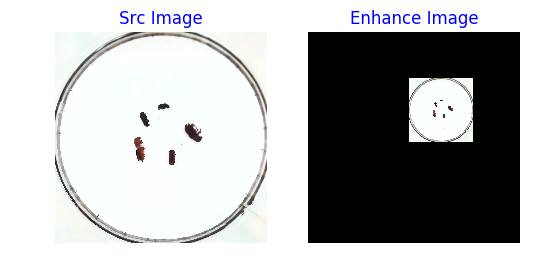

In [ ]:
# 随机填充
def random_expand(img,
                  gtboxes,
                  max_ratio=4.,
                  fill=None,
                  keep_ratio=True,
                  thresh=0.5):
    if random.random() > thresh:
        return img, gtboxes

    if max_ratio < 1.0:
        return img, gtboxes

    h, w, c = img.shape
    ratio_x = random.uniform(1, max_ratio)
    if keep_ratio:
        ratio_y = ratio_x
    else:
        ratio_y = random.uniform(1, max_ratio)
    oh = int(h * ratio_y)
    ow = int(w * ratio_x)
    off_x = random.randint(0, ow - w)
    off_y = random.randint(0, oh - h)

    out_img = np.zeros((oh, ow, c))
    if fill and len(fill) == c:
        for i in range(c):
            out_img[:, :, i] = fill[i] * 255.0

    out_img[off_y:off_y + h, off_x:off_x + w, :] = img
    gtboxes[:, 0] = ((gtboxes[:, 0] * w) + off_x) / float(ow)
    gtboxes[:, 1] = ((gtboxes[:, 1] * h) + off_y) / float(oh)
    gtboxes[:, 2] = gtboxes[:, 2] / ratio_x
    gtboxes[:, 3] = gtboxes[:, 3] / ratio_y

    return out_img.astype('uint8'), gtboxes

srcimg_gtbox = records[0]['gt_bbox']
srcimg_label = records[0]['gt_class']

img_enhance, new_gtbox = random_expand(srcimg, srcimg_gtbox)
visualize(srcimg, img_enhance)

#### **随机缩放**

src image shape:(1258, 1258, 3), resize imgage shape:(640, 640, 3)


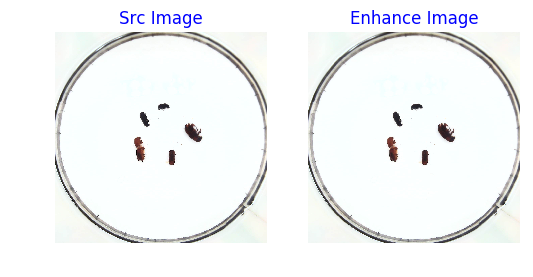

In [ ]:
# 随机缩放
def random_interp(img, size, interp=None):
    interp_method = [
        cv2.INTER_NEAREST,
        cv2.INTER_LINEAR,
        cv2.INTER_AREA,
        cv2.INTER_CUBIC,
        cv2.INTER_LANCZOS4,
    ]
    if not interp or interp not in interp_method:
        interp = interp_method[random.randint(0, len(interp_method) - 1)]
    h, w, _ = img.shape
    im_scale_x = size / float(w)
    im_scale_y = size / float(h)
    img = cv2.resize(
        img, None, None, fx=im_scale_x, fy=im_scale_y, interpolation=interp)
    return img

# 对原图做 随机缩放
random_size = 640
img_enhance = random_interp(srcimg, random_size)
visualize(srcimg, img_enhance)
print('src image shape:{}, resize imgage shape:{}'.format(srcimg.shape, img_enhance.shape))

#### **随机翻转**

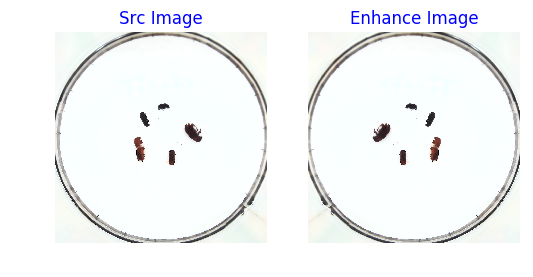

In [ ]:
# 随机翻转
def random_flip(img, gtboxes, thresh=0.5):
    if random.random() > thresh:
        img = img[:, ::-1, :]
        gtboxes[:, 0] = 1.0 - gtboxes[:, 0]
    return img, gtboxes


# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
img_enhance, box_enhance = random_flip(srcimg, srcimg_gtbox)
visualize(srcimg, img_enhance)

#### **随机打乱真实框排列顺序**

In [ ]:
# 随机打乱真实框排列顺序
def shuffle_gtbox(gtbox, gtlabel):
    gt = np.concatenate(
        [gtbox, gtlabel[:, np.newaxis]], axis=1)
    idx = np.arange(gt.shape[0])
    np.random.shuffle(idx)
    gt = gt[idx, :]
    return gt[:, :4], gt[:, 4]

#### **图像增广方法汇总**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


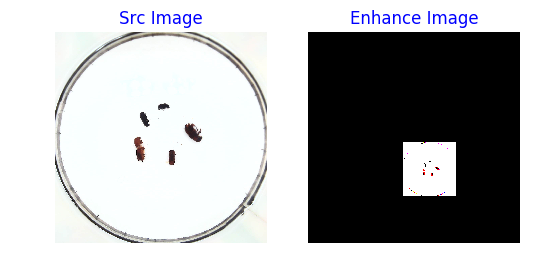

In [ ]:
# 图像增广方法汇总
def image_augment(img, gtboxes, gtlabels, size, means=None):
    # 随机改变亮暗、对比度和颜色等
    img = random_distort(img)
    # 随机填充
    img, gtboxes = random_expand(img, gtboxes, fill=means)
    # 随机缩放
    img = random_interp(img, size)
    # 随机翻转
    img, gtboxes = random_flip(img, gtboxes)
    # 随机打乱真实框排列顺序
    gtboxes, gtlabels = shuffle_gtbox(gtboxes, gtlabels)

    return img.astype('float32'), gtboxes.astype('float32'), gtlabels.astype('int32')

img_enhance, img_box, img_label = image_augment(srcimg, srcimg_gtbox, srcimg_label, size=320)
visualize(srcimg, img_enhance)

In [ ]:
img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
size = 512
img, gt_boxes, gt_labels = image_augment(img, gt_boxes, gt_labels, size)
print('img shape:{}\n gt_boxes shape:{}\n gt_labels shape:{}'.format(img.shape, gt_boxes.shape, gt_labels.shape))

img shape:(512, 512, 3)
 gt_boxes shape:(50, 4)
 gt_labels shape:(50,)


这里得到的img数据数值需要调整，需要除以255，并且减去均值和方差，再将维度从[H, W, C]调整为[C, H, W]。

In [ ]:
img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
size = 512
img, gt_boxes, gt_labels = image_augment(img, gt_boxes, gt_labels, size)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean = np.array(mean).reshape((1, 1, -1))
std = np.array(std).reshape((1, 1, -1))
img = (img / 255.0 - mean) / std
img = img.astype('float32').transpose((2, 0, 1))

将上面的过程整理成一个`get_img_data`函数。

In [ ]:
def get_img_data(record, size=640):
    img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
    img, gt_boxes, gt_labels = image_augment(img, gt_boxes, gt_labels, size)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    mean = np.array(mean).reshape((1, 1, -1))
    std = np.array(std).reshape((1, 1, -1))
    img = (img / 255.0 - mean) / std
    img = img.astype('float32').transpose((2, 0, 1))
    return img, gt_boxes, gt_labels, scales

In [ ]:
TRAINDIR = '/home/aistudio/work/insects/train'
TESTDIR = '/home/aistudio/work/insects/test'
VALIDDIR = '/home/aistudio/work/insects/val'
cname2cid = get_insect_names()
records = get_annotations(cname2cid, TRAINDIR)

record = records[0]
img, gt_boxes, gt_labels, scales = get_img_data(record, size=480)
print('img shape:{} \n gt_boxes shape:{}\n gt_bales:{}\n scales:{}'.format(img.shape, gt_boxes.shape, gt_labels, scales))

img shape:(3, 480, 480) 
 gt_boxes shape:(50, 4)
 gt_bales:[0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 3 0 5 0 0 0]
 scales:(1288.0, 1288.0)


### 5.3.1.4 批量数据读取

上面的程序展示了如何读取一张图片的数据并加速，但在真实场景的模型训练与评估过程中，通常会使用批量数据读取和预处理的方式。下面代码实现了批量数据读取。

In [ ]:
# 获取一个批次内样本随机缩放的尺寸
def get_img_size(mode):
    if (mode == 'train') or (mode == 'valid'):
        inds = np.array([0,1,2,3,4,5,6,7,8,9])
        ii = np.random.choice(inds)
        img_size = 320 + ii * 32
    else:
        img_size = 608
    return img_size

# 将 list形式的batch数据 转化成多个array构成的tuple
def make_array(batch_data):
    img_array = np.array([item[0] for item in batch_data], dtype = 'float32')
    gt_box_array = np.array([item[1] for item in batch_data], dtype = 'float32')
    gt_labels_array = np.array([item[2] for item in batch_data], dtype = 'int32')
    img_scale = np.array([item[3] for item in batch_data], dtype='int32')
    return img_array, gt_box_array, gt_labels_array, img_scale

由于数据预处理耗时较长，可能会成为网络训练速度的瓶颈，所以需要对预处理部分进行优化。通过使用飞桨提供的[paddle.io.DataLoader](https://www.paddlepaddle.org.cn/documentation/docs/en/develop/api/paddle/io/DataLoader_en.html) API中的num_workers参数设置进程数量，实现多进程读取数据，具体实现代码如下。

In [ ]:
import paddle

# 定义数据读取类，继承Paddle.io.Dataset
class TrainDataset(paddle.io.Dataset):
    def  __init__(self, datadir, mode='train'):
        self.datadir = datadir
        cname2cid = get_insect_names()
        self.records = get_annotations(cname2cid, datadir)
        self.img_size = 640  #get_img_size(mode)

    def __getitem__(self, idx):
        record = self.records[idx]
        # print("print: ", record)
        img, gt_bbox, gt_labels, im_shape = get_img_data(record, size=self.img_size)

        return img, gt_bbox, gt_labels, np.array(im_shape)

    def __len__(self):
        return len(self.records)

# 创建数据读取类
train_dataset = TrainDataset(TRAINDIR, mode='train')

# 使用paddle.io.DataLoader创建数据读取器，并设置batchsize，进程数量num_workers等参数
train_loader = paddle.io.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, drop_last=True)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


In [ ]:
img, gt_boxes, gt_labels, im_shape = next(train_loader())
print('img shape:{}\n gt_boxes shape:{}\n gt_labels shape:{}'.format(img.shape, gt_boxes.shape, gt_labels.shape))

至此，我们完成了如何查看数据集中的数据、提取数据标注信息、从文件读取图像和标注数据、图像增广、批量读取和加速等过程，通过`paddle.io.Dataset`可以返回img, gt_boxes, gt_labels, im_shape等数据，接下来就可以将它们输入到神经网络，应用到具体算法上了。

在开始具体的算法讲解之前，先补充一下读取测试数据的代码。测试数据没有标注信息，也不需要做图像增广，代码如下所示。

In [ ]:
import os
# 将 list形式的batch数据 转化成多个array构成的tuple
def make_test_array(batch_data):
    img_name_array = np.array([item[0] for item in batch_data])
    img_data_array = np.array([item[1] for item in batch_data], dtype = 'float32')
    img_scale_array = np.array([item[2] for item in batch_data], dtype='int32')
    return img_name_array, img_data_array, img_scale_array

# 测试数据读取
def test_data_loader(datadir, batch_size= 10, test_image_size=608, mode='test'):
    """
    加载测试用的图片，测试数据没有groundtruth标签
    """
    image_names = os.listdir(datadir)
    def reader():
        batch_data = []
        img_size = test_image_size
        for image_name in image_names:
            file_path = os.path.join(datadir, image_name)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            H = img.shape[0]
            W = img.shape[1]
            img = cv2.resize(img, (img_size, img_size))

            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            mean = np.array(mean).reshape((1, 1, -1))
            std = np.array(std).reshape((1, 1, -1))
            out_img = (img / 255.0 - mean) / std
            out_img = out_img.astype('float32').transpose((2, 0, 1))
            img = out_img #np.transpose(out_img, (2,0,1))
            im_shape = [H, W]

            batch_data.append((image_name.split('.')[0], img, im_shape))
            if len(batch_data) == batch_size:
                yield make_test_array(batch_data)
                batch_data = []
        if len(batch_data) > 0:
            yield make_test_array(batch_data)

    return reader

## 5.3.2  模型构建

使用上一节定义好的YOLOv3网络结构，封装在`/home/aistudio/yolo.py`文件内：

In [ ]:
from yolo import YOLOv3

## 5.3.3 损失函数  

飞桨已经将loss封装好，直接计算损失函数，过程更简洁，速度也更快，推荐大家直接使用飞桨 [paddle.vision.ops.yolo_loss](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-rc1/api/paddle/vision/ops/yolo_loss_cn.html) API，关键参数说明如下：

> paddle.vision.ops.yolo_loss(x, gt_box, gt_label, anchors, anchor_mask, class_num, ignore_thresh, downsample_ratio, gt_score=None, use_label_smooth=True, name=None, scale_x_y=1.0)

- x: 输出特征图。
- gt_box: 真实框。
- gt_label: 真实框标签。
- ignore_thresh，预测框与真实框IoU阈值超过ignore_thresh时，不作为负样本，YOLOv3模型里设置为0.7。
- downsample_ratio，特征图P0的下采样比例，使用Darknet53骨干网络时为32。
- gt_score，真实框的置信度，在使用了mixup技巧时用到。
- use_label_smooth，一种训练技巧，如不使用，设置为False。
- name，该层的名字，比如'yolov3_loss'，默认值为None，一般无需设置。

YOLOv3的模型代码如下所示：

In [ ]:
def get_loss(num_classes, outputs, gtbox, gtlabel, gtscore=None,
                anchors = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326],
                anchor_masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]],
                ignore_thresh=0.7,
                use_label_smooth=False):
    """
    使用paddle.vision.ops.yolo_loss
    """
    losses = []
    downsample = 32
    for i, out in enumerate(outputs): # 对三个层级分别求损失函数
        anchor_mask_i = anchor_masks[i]
        loss = paddle.vision.ops.yolo_loss(
                x=out,  # out是P0, P1, P2中的一个
                gt_box=gtbox,  # 真实框坐标
                gt_label=gtlabel,  # 真实框类别
                gt_score=gtscore,  # 真实框得分，使用mixup训练技巧时需要，不使用该技巧时直接设置为1，形状与gtlabel相同
                anchors=anchors,   # 锚框尺寸，包含[w0, h0, w1, h1, ..., w8, h8]共9个锚框的尺寸
                anchor_mask=anchor_mask_i, # 筛选锚框的mask，例如anchor_mask_i=[3, 4, 5]，将anchors中第3、4、5个锚框挑选出来给该层级使用
                class_num=num_classes, # 分类类别数
                ignore_thresh=ignore_thresh, # 当预测框与真实框IoU > ignore_thresh，标注objectness = -1
                downsample_ratio=downsample, # 特征图相对于原图缩小的倍数，例如P0是32， P1是16，P2是8
                use_label_smooth=False)      # 使用label_smooth训练技巧时会用到，这里没用此技巧，直接设置为False
        losses.append(paddle.mean(loss))  #mean对每张图片求和
        downsample = downsample // 2 # 下一级特征图的缩放倍数会减半
    return sum(losses) # 对每个层级求和

## 5.3.4 模型训练

训练过程如 **图3** 所示，输入图片经过特征提取得到三个层级的输出特征图P0(stride=32)、P1(stride=16)和P2(stride=8)，相应的分别使用不同大小的小方块区域去生成对应的锚框和预测框，并对这些锚框进行标注。

- P0层级特征图，对应着使用$32\times32$大小的小方块，在每个区域中心生成大小分别为$[116, 90]$, $[156, 198]$, $[373, 326]$的三种锚框。

- P1层级特征图，对应着使用$16\times16$大小的小方块，在每个区域中心生成大小分别为$[30, 61]$, $[62, 45]$, $[59, 119]$的三种锚框。

- P2层级特征图，对应着使用$8\times8$大小的小方块，在每个区域中心生成大小分别为$[10, 13]$, $[16, 30]$, $[33, 23]$的三种锚框。

将三个层级的特征图与对应锚框之间的标签关联起来，并建立损失函数，总的损失函数等于三个层级的损失函数相加。通过极小化损失函数，可以开启端到端的训练过程。

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/736da9cd3a4f4a1c98187a6cdf1a0334af73470b6d7c4b2fbaa9660d4bd20621" width = "600"></center>
<center><br>图3：端到端训练流程 </br></center>
<br></br>

训练过程的具体实现代码如下，训练时长原因，epoch先设置为1，如果训练更优模型，调大该值。

In [22]:
############# 这段代码在本地机器上运行请慎重，容易造成死机，我们可以使用较小的MAX_EPOCH运行#######################

import time
import os
import paddle

def get_lr(base_lr = 0.0001, lr_decay = 0.1):
    bd = [10000, 20000]
    lr = [base_lr, base_lr * lr_decay, base_lr * lr_decay * lr_decay]
    learning_rate = paddle.optimizer.lr.PiecewiseDecay(boundaries=bd, values=lr)
    return learning_rate

# MAX_EPOCH = 200
MAX_EPOCH = 1

ANCHORS = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326]

ANCHOR_MASKS = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]

IGNORE_THRESH = .7
NUM_CLASSES = 7

TRAINDIR = '/home/aistudio/work/insects/train'
TESTDIR = '/home/aistudio/work/insects/test'
VALIDDIR = '/home/aistudio/work/insects/val'
paddle.set_device("gpu:0")
# 创建数据读取类
train_dataset = TrainDataset(TRAINDIR, mode='train')
valid_dataset = TrainDataset(VALIDDIR, mode='valid')
test_dataset = TrainDataset(VALIDDIR, mode='valid')
# 使用paddle.io.DataLoader创建数据读取器，并设置batchsize，进程数量num_workers等参数
train_loader = paddle.io.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0, drop_last=True, use_shared_memory=False)
valid_loader = paddle.io.DataLoader(valid_dataset, batch_size=10, shuffle=False, num_workers=0, drop_last=False, use_shared_memory=False)
model = YOLOv3(num_classes = NUM_CLASSES)  #创建模型
learning_rate = get_lr()
opt = paddle.optimizer.Momentum(
                learning_rate=learning_rate,
                momentum=0.9,
                weight_decay=paddle.regularizer.L2Decay(0.0005),
                parameters=model.parameters())  #创建优化器
# opt = paddle.optimizer.Adam(learning_rate=learning_rate, weight_decay=paddle.regularizer.L2Decay(0.0005), parameters=model.parameters())


if __name__ == '__main__':
    for epoch in range(MAX_EPOCH):
        for i, data in enumerate(train_loader()):
            img, gt_boxes, gt_labels, img_scale = data
            gt_scores = np.ones(gt_labels.shape).astype('float32')
            gt_scores = paddle.to_tensor(gt_scores)
            img = paddle.to_tensor(img)
            gt_boxes = paddle.to_tensor(gt_boxes)
            gt_labels = paddle.to_tensor(gt_labels)
            outputs = model(img)  #前向传播，输出[P0, P1, P2]
            loss = get_loss(NUM_CLASSES, outputs, gt_boxes, gt_labels, gtscore=gt_scores,
                                  anchors = ANCHORS,
                                  anchor_masks = ANCHOR_MASKS,
                                  ignore_thresh=IGNORE_THRESH,
                                  use_label_smooth=False)        # 计算损失函数

            loss.backward()    # 反向传播计算梯度
            opt.step()  # 更新参数
            opt.clear_grad()
            if i % 10 == 0:
                timestring = time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()))
                print('{}[TRAIN]epoch {}, iter {}, output loss: {}'.format(timestring, epoch, i, loss.numpy()))

        # save params of model
        if (epoch % 5 == 0) or (epoch == MAX_EPOCH -1):
            paddle.save(model.state_dict(), 'yolo_epoch{}'.format(epoch))

        # 每个epoch结束之后在验证集上进行测试
        model.eval()
        for i, data in enumerate(valid_loader()):
            img, gt_boxes, gt_labels, img_scale = data
            gt_scores = np.ones(gt_labels.shape).astype('float32')
            gt_scores = paddle.to_tensor(gt_scores)
            img = paddle.to_tensor(img)
            gt_boxes = paddle.to_tensor(gt_boxes)
            gt_labels = paddle.to_tensor(gt_labels)
            outputs = model(img)
            loss = get_loss(NUM_CLASSES,outputs, gt_boxes, gt_labels, gtscore=gt_scores,
                                  anchors = ANCHORS,
                                  anchor_masks = ANCHOR_MASKS,
                                  ignore_thresh=IGNORE_THRESH,
                                  use_label_smooth=False)
            if i % 1 == 0:
                timestring = time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()))
                print('{}[VALID]epoch {}, iter {}, output loss: {}'.format(timestring, epoch, i, loss.numpy()))
        model.train()

## 5.3.5  模型评估

先定义上一节讲解的非极大值抑制，当数据集中含有多个类别的物体时，需要做多分类非极大值抑制，其实现原理与非极大值抑制相同，区别在于需要对每个类别都做非极大值抑制，实现代码如下面的multiclass_nms所示。

In [ ]:
# 计算IoU，矩形框的坐标形式为xyxy，这个函数会被保存在box_utils.py文件中
def box_iou_xyxy(box1, box2):
    # 获取box1左上角和右下角的坐标
    x1min, y1min, x1max, y1max = box1[0], box1[1], box1[2], box1[3]
    # 计算box1的面积
    s1 = (y1max - y1min + 1.) * (x1max - x1min + 1.)
    # 获取box2左上角和右下角的坐标
    x2min, y2min, x2max, y2max = box2[0], box2[1], box2[2], box2[3]
    # 计算box2的面积
    s2 = (y2max - y2min + 1.) * (x2max - x2min + 1.)
    
    # 计算相交矩形框的坐标
    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    # 计算相交矩形行的高度、宽度、面积
    inter_h = np.maximum(ymax - ymin + 1., 0.)
    inter_w = np.maximum(xmax - xmin + 1., 0.)
    intersection = inter_h * inter_w
    # 计算相并面积
    union = s1 + s2 - intersection
    # 计算交并比
    iou = intersection / union
    return iou

# 非极大值抑制
def nms(bboxes, scores, score_thresh, nms_thresh, pre_nms_topk, i=0, c=0):
    """
    nms
    """
    inds = np.argsort(scores)
    inds = inds[::-1]
    keep_inds = []
    while(len(inds) > 0):
        cur_ind = inds[0]
        cur_score = scores[cur_ind]
        # if score of the box is less than score_thresh, just drop it
        if cur_score < score_thresh:
            break

        keep = True
        for ind in keep_inds:
            current_box = bboxes[cur_ind]
            remain_box = bboxes[ind]
            iou = box_iou_xyxy(current_box, remain_box)
            if iou > nms_thresh:
                keep = False
                break
        if i == 0 and c == 4 and cur_ind == 951:
            print('suppressed, ', keep, i, c, cur_ind, ind, iou)
        if keep:
            keep_inds.append(cur_ind)
        inds = inds[1:]

    return np.array(keep_inds)

# 多分类非极大值抑制
def multiclass_nms(bboxes, scores, score_thresh=0.01, nms_thresh=0.45, pre_nms_topk=1000, pos_nms_topk=100):
    """
    This is for multiclass_nms
    """
    batch_size = bboxes.shape[0]
    class_num = scores.shape[1]
    rets = []
    for i in range(batch_size):
        bboxes_i = bboxes[i]
        scores_i = scores[i]
        ret = []
        for c in range(class_num):
            scores_i_c = scores_i[c]
            keep_inds = nms(bboxes_i, scores_i_c, score_thresh, nms_thresh, pre_nms_topk, i=i, c=c)
            if len(keep_inds) < 1:
                continue
            keep_bboxes = bboxes_i[keep_inds]
            keep_scores = scores_i_c[keep_inds]
            keep_results = np.zeros([keep_scores.shape[0], 6])
            keep_results[:, 0] = c
            keep_results[:, 1] = keep_scores[:]
            keep_results[:, 2:6] = keep_bboxes[:, :]
            ret.append(keep_results)
        if len(ret) < 1:
            rets.append(ret)
            continue
        ret_i = np.concatenate(ret, axis=0)
        scores_i = ret_i[:, 1]
        if len(scores_i) > pos_nms_topk:
            inds = np.argsort(scores_i)[::-1]
            inds = inds[:pos_nms_topk]
            ret_i = ret_i[inds]

        rets.append(ret_i)

    return rets

运行如下代码启动评估，需要指定待评估的图片文件存放路径和需要使用到的模型参数。评估结果会被保存在pred_results.json文件中。

为了演示计算过程，下面使用的是验证集下的图片"insects/val/images"，在提交比赛结果的时候，请使用测试集图片"insects/test/images"

这里提供的yolo_epoch50.pdparams 是未充分训练好的权重参数，请在比赛时换成自己训练好的权重参数


In [ ]:
import json
import paddle

ANCHORS = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326]

ANCHOR_MASKS = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]

VALID_THRESH = 0.01

NMS_TOPK = 400
NMS_POSK = 100
NMS_THRESH = 0.45

NUM_CLASSES = 7

# 在验证集val上评估训练模型
TESTDIR = '/home/aistudio/work/insects/val/images' #请将此目录修改成用户自己保存测试图片的路径
WEIGHT_FILE = '/home/aistudio/yolo_epoch50.pdparams' # 请将此文件名修改成用户自己训练好的权重参数存放路径


# 在测试集test上评估训练模型
# TESTDIR = '/home/aistudio/work/insects/test/images'
# WEIGHT_FILE = '/home/aistudio/yolo_epoch50.pdparams'

if __name__ == '__main__':
    model = YOLOv3(num_classes=NUM_CLASSES)
    params_file_path = WEIGHT_FILE
    model_state_dict = paddle.load(params_file_path)
    model.load_dict(model_state_dict)
    model.eval()

    total_results = []
    test_loader = test_data_loader(TESTDIR, batch_size= 1, mode='test')
    for i, data in enumerate(test_loader()):
        img_name, img_data, img_scale_data = data
        img = paddle.to_tensor(img_data)
        img_scale = paddle.to_tensor(img_scale_data)

        outputs = model.forward(img)
        bboxes, scores = model.get_pred(outputs,
                                 im_shape=img_scale,
                                 anchors=ANCHORS,
                                 anchor_masks=ANCHOR_MASKS,
                                 valid_thresh = VALID_THRESH)

        bboxes_data = bboxes.numpy()
        scores_data = scores.numpy()
        result = multiclass_nms(bboxes_data, scores_data,
                      score_thresh=VALID_THRESH, 
                      nms_thresh=NMS_THRESH, 
                      pre_nms_topk=NMS_TOPK, 
                      pos_nms_topk=NMS_POSK)
        for j in range(len(result)):
            result_j = result[j]
            img_name_j = img_name[j]
            total_results.append([img_name_j, result_j.tolist()])
        print('processed {} pictures'.format(len(total_results)))

    print('')
    json.dump(total_results, open('pred_results.json', 'w'))

json文件中保存着测试结果，是包含所有图片预测结果的list，其构成如下：

    [[img_name, [[label, score, x1, y1, x2, y2], ..., [label, score, x1, y1, x2, y2]]], 
     [img_name, [[label, score, x1, y1, x2, y2], ..., [label, score, x1, y1, x2, y2]]],
      ...
     [img_name, [[label, score, x1, y1, x2, y2],..., [label, score, x1, y1, x2, y2]]]]

list中的每一个元素是一张图片的预测结果，list的总长度等于图片的数目，每张图片预测结果的格式是：

     [img_name, [[label, score, x1, y1, x2, y2],..., [label, score, x1, y1, x2, y2]]]
     
其中第一个元素是图片名称image_name，第二个元素是包含该图片所有预测框的list， 预测框列表：

     [[label, score, x1, x2, y1, y2],..., [label, score, x1, y1, x2, y2]]
     
预测框列表中每个元素[label, score, x1, y1, x2, y2]描述了一个预测框，label是预测框所属类别标签，score是预测框的得分；x1, y1, x2, y2对应预测框左上角坐标(x1, y1)，右下角坐标(x2, y2)。每张图片可能有很多个预测框，则将其全部放在预测框列表中。

#### 计算精度指标

通过运行如下代码计算最终精度指标mAP

同学们训练完之后，可以在val数据集上计算mAP查看结果，所以下面用到的是val标注数据"insects/val/annotations/xmls"

提交比赛成绩的话需要在测试集上计算mAP，本地没有测试集的标注，只能提交json文件到比赛服务器上查看成绩

In [ ]:
# -*- coding: utf-8 -*-

import os
import json
import numpy as np
import xml.etree.ElementTree as ET
from map_utils import DetectionMAP

# 存放测试集标签的目录
annotations_dir ="/home/aistudio/work/insects/val/annotations/xmls"

# 存放预测结果的文件
pred_result_file = "pred_results.json"
# pred_result_file 中保存着测试结果，是包含所有图片预测结果的list，其构成如下
# [[img_name, [[label, score, x1, x2, y1, y2],..., [label, score, x1, x2, y1, y2]]], 
#  [img_name, [[label, score, x1, x2, y1, y2],..., [label, score, x1, x2, y1, y2]]],
#  ...
#  [img_name, [[label, score, x1, x2, y1, y2],..., [label, score, x1, x2, y1, y2]]]]
# list中的每一个元素是一张图片的预测结果，list的总长度等于图片的数目
# 每张图片预测结果的格式是: [img_name, [[label, score, x1, x2, y1, y2],..., [label, score, x1, x2, y1, y2]]]
# 其中第一个元素是图片名称image_name，第二个元素是包含所有预测框的列表
# 预测框列表中每个元素[label, score, x1, x2, y1, y2]描述了一个预测框，
# label是预测框所属类别标签，score是预测框的得分
# x1, x2, y1, y2对应预测框左上角坐标(x1, y1)，右下角坐标(x2, y2)
# 每张图片可能有很多个预测框，则将其全部放在预测框列表中

overlap_thresh = 0.5
map_type = '11point'
insect_names = ['Boerner', 'Leconte', 'Linnaeus', 'acuminatus', 'armandi', 'coleoptera', 'linnaeus']

if __name__ == '__main__':
    cname2cid = {}
    for i, item in enumerate(insect_names):
        cname2cid[item] = i
    filename = pred_result_file
    results = json.load(open(filename))
    num_classes = len(insect_names)
    detection_map = DetectionMAP(class_num=num_classes,
                        overlap_thresh=overlap_thresh,
                        map_type=map_type,
                        is_bbox_normalized=False,
                        evaluate_difficult=False)
    for result in results:
        image_name = str(result[0])
        bboxes = np.array(result[1]).astype('float32')
        anno_file = os.path.join(annotations_dir, image_name + '.xml')
        tree = ET.parse(anno_file)
        objs = tree.findall('object')
        im_w = float(tree.find('size').find('width').text)
        im_h = float(tree.find('size').find('height').text)
        gt_bbox = np.zeros((len(objs), 4), dtype=np.float32)
        gt_class = np.zeros((len(objs), 1), dtype=np.int32)
        difficult = np.zeros((len(objs), 1), dtype=np.int32)
        for i, obj in enumerate(objs):
            cname = obj.find('name').text
            gt_class[i][0] = cname2cid[cname]
            _difficult = int(obj.find('difficult').text)
            x1 = float(obj.find('bndbox').find('xmin').text)
            y1 = float(obj.find('bndbox').find('ymin').text)
            x2 = float(obj.find('bndbox').find('xmax').text)
            y2 = float(obj.find('bndbox').find('ymax').text)
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(im_w - 1, x2)
            y2 = min(im_h - 1, y2)
            gt_bbox[i] = [x1, y1, x2, y2]
            difficult[i][0] = _difficult
        detection_map.update(bboxes, gt_bbox, gt_class, difficult)

    print("Accumulating evaluatation results...")
    detection_map.accumulate()
    map_stat = 100. * detection_map.get_map()
    print("mAP({:.2f}, {}) = {:.2f}".format(overlap_thresh,
                            map_type, map_stat))

Accumulating evaluatation results...
mAP(0.50, 11point) = 71.97


## 5.3.6 模型预测

预测过程流程 **图4** 如下所示：

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/15c140b1844d419cbe237b1a70f4099266aa168c05dc413f8e232f688050fa75" width = "400"></center>
<center><br>图4：预测流程 </br></center>
<br></br>

预测过程可以分为两步：

1. 通过`get_pred`函数预测框位置和所属类别的得分。 
2. 使用非极大值抑制来消除重叠较大的预测框。

首先定义绘制预测框的画图函数，代码如下。

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread
import math

# 定义画图函数
INSECT_NAMES = ['Boerner', 'Leconte', 'Linnaeus', 
                'acuminatus', 'armandi', 'coleoptera', 'linnaeus']

# 定义画矩形框的函数 
def draw_rectangle(currentAxis, bbox, edgecolor = 'k', facecolor = 'y', fill=False, linestyle='-'):
    # currentAxis，坐标轴，通过plt.gca()获取
    # bbox，边界框，包含四个数值的list， [x1, y1, x2, y2]
    # edgecolor，边框线条颜色
    # facecolor，填充颜色
    # fill, 是否填充
    # linestype，边框线型
    # patches.Rectangle需要传入左上角坐标、矩形区域的宽度、高度等参数
    rect=patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1, linewidth=1,
                           edgecolor=edgecolor,facecolor=facecolor,fill=fill, linestyle=linestyle)
    currentAxis.add_patch(rect)

# 定义绘制预测结果的函数
def draw_results(result, filename, draw_thresh=0.5):
    plt.figure(figsize=(10, 10))
    im = cv2.imread(filename)
    plt.imshow(im)
    currentAxis=plt.gca()
    colors = ['r', 'g', 'b', 'k', 'y', 'c', 'purple']
    for item in result:
        box = item[2:6]
        label = int(item[0])
        name = INSECT_NAMES[label]
        if item[1] > draw_thresh:
            draw_rectangle(currentAxis, box, edgecolor = colors[label])
            plt.text(box[0], box[1], name, fontsize=12, color=colors[label])

使用5.3.1.4 小节定义的`test_data_loader`函数读取指定的图片，输入网络并计算出预测框和得分，然后使用多分类非极大值抑制消除冗余的框。将最终结果画图展示出来。

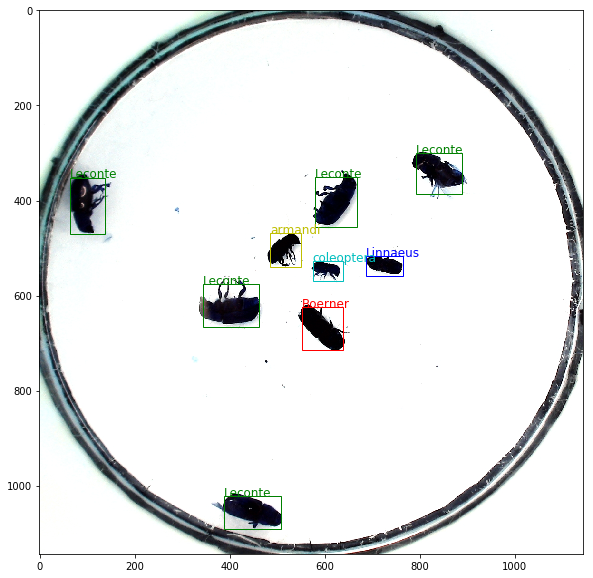

In [ ]:
import json

import paddle

ANCHORS = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326]
ANCHOR_MASKS = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
VALID_THRESH = 0.01
NMS_TOPK = 400
NMS_POSK = 100
NMS_THRESH = 0.45

NUM_CLASSES = 7
if __name__ == '__main__':
    image_name = '/home/aistudio/work/insects/test/images/2642.jpeg'
    params_file_path = '/home/aistudio/yolo_epoch50.pdparams'

    model = YOLOv3(num_classes=NUM_CLASSES)
    model_state_dict = paddle.load(params_file_path)
    model.load_dict(model_state_dict)
    model.eval()

    total_results = []
    test_loader = test_data_loader(image_name, mode='test')
    for i, data in enumerate(test_loader()):
        img_name, img_data, img_scale_data = data
        img = paddle.to_tensor(img_data)
        img_scale = paddle.to_tensor(img_scale_data)

        outputs = model.forward(img)
        bboxes, scores = model.get_pred(outputs,
                                 im_shape=img_scale,
                                 anchors=ANCHORS,
                                 anchor_masks=ANCHOR_MASKS,
                                 valid_thresh = VALID_THRESH)

        bboxes_data = bboxes.numpy()
        scores_data = scores.numpy()
        results = multiclass_nms(bboxes_data, scores_data,
                      score_thresh=VALID_THRESH, 
                      nms_thresh=NMS_THRESH, 
                      pre_nms_topk=NMS_TOPK, 
                      pos_nms_topk=NMS_POSK)

result = results[0]
draw_results(result, image_name, draw_thresh=0.4)

通过上面的程序，清晰的给读者展示了如何使用训练好的权重，对图片进行预测并将结果可视化。最终输出的图片上，检测出了每个昆虫，标出了它们的边界框和具体类别。

# 提升方案

这里给出的是一份基础版本的代码，可以在上面继续改进提升，可以使用的改进方案有：

1、使用其它模型如faster rcnn等 （难度系数5）

2、使用数据增多，可以对原图进行翻转、裁剪等操作 （难度系数3）

3、修改anchor参数的设置，教案中的anchor参数设置直接使用原作者在coco数据集上的设置，针对此模型是否要调整 （难度系数3）

4、调整优化器、学习率策略、正则化系数等是否能提升模型精度 （难度系数1）


# 总结
   本章系统化的介绍了计算机视觉的各种网络结构和发展历程，并以图像分类和目标检测两个任务为例，展示了ResNet和YOLOv3等算法的实现。期望读者不仅掌握了计算机视觉模型搭建方法，也能够对提取视觉特征的方法有更深入的认知。
   
# 作业
   修改模型参数，对比添加多尺度特征融合前后模型的效果。